<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/OCW_Recommendation_and_Unsupervised_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

#Load Data

In [2]:
api_token = {"username":"srhgccc","key":"41c36ccc1ee7bc07f70e459ccbf7df7c"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

In [3]:
!kaggle datasets download -d srhgccc/ocw-dataset

 46% 9.00M/19.6M [00:00<00:00, 26.3MB/s]
100% 19.6M/19.6M [00:00<00:00, 53.2MB/s]


In [4]:
!unzip ocw-dataset.zip

Archive:  ocw-dataset.zip
  inflating: GA_ver3.csv             
  inflating: MergeOCW.csv            
  inflating: NewOCW.csv              
  inflating: ocwlist_ver3.csv        


In [5]:
import numpy as np
import pandas as pd

In [6]:
dataset = pd.read_csv('NewOCW.csv')
dataset = dataset.dropna()
dataset['client_id'] = dataset['client_id'].astype('str')
dataset['date'] = pd.to_datetime(dataset['date'])
dateset = dataset.sort_values(by='date', ascending=True, inplace=True)
dataset = dataset.drop(columns=['page', 'links'])

In [7]:
print(dataset.shape)

(312521, 8)


In [8]:
import time
from datetime import datetime

dataset['time_delta'] = (max(dataset['date']) - dataset['date'])
dataset['time_delta'] = list(map(lambda x: x.days, dataset['time_delta']))

In [9]:
r = 0.75
dataset['user_score'] = r**dataset['time_delta']

In [10]:
dataset.head(2)

,client_id,date,title,college,department,professor_name,total_click_times,month_click_times,time_delta,user_score
40893,44598215.1569772,2020-03-20 16:14:28.611336+00:00,古典社會學理論,社科院,社會學系,孫中興,196678,669,771,4.701474e-97
176733,117994036.158455,2020-03-20 16:14:57.640742+00:00,英語語音學 (含發音練習) 一,文學院,外國語文學系,史嘉琳,1310409,7847,771,4.701474e-97


In [11]:
user_mappings = {k:v for v, k in enumerate(dataset['client_id'].unique())}
dataset['client_id'] = dataset['client_id'].map(user_mappings)

#Data Preprocessing

In [12]:
dataset['hour'] = list(map(lambda x: str(x)[11:13], dataset['date']))
cc = dataset.groupby('client_id')['title'].nunique()
cc = pd.DataFrame(cc)
cc = cc.rename(columns={'title': 'number'})
dataset = pd.merge(dataset, cc, on="client_id")

In [13]:
dataset.head(2)

,client_id,date,title,college,department,professor_name,total_click_times,month_click_times,time_delta,user_score,hour,number
0,0,2020-03-20 16:14:28.611336+00:00,古典社會學理論,社科院,社會學系,孫中興,196678,669,771,4.701474e-97,16,13
1,0,2020-03-21 16:46:47.137401+00:00,古典社會學理論,社科院,社會學系,孫中興,196678,669,770,6.268633e-97,16,13


# Input Output Split

In [14]:
# Use previous x-n behaviors to predict last n behaviors
from tqdm import tqdm

X = pd.DataFrame()
Y = pd.DataFrame()
n = 1
person = []
for i in tqdm(range(max(dataset['client_id'])+1)):
  temp = dataset[dataset['client_id'] == i]
  if temp.shape[0] < n+1:
    person.append(i)
    continue
  X = pd.concat([X, temp.iloc[:-n, :]], axis = 0)  #rbind
  Y = pd.concat([Y, temp.iloc[-n:, :]], axis = 0)  
del temp

100%|██████████| 9351/9351 [02:36<00:00, 59.67it/s]


In [15]:
print(X.shape)
print(Y.shape)

(303170, 12)
(9291, 12)


# Train Test Split

In [16]:
from random import sample
import random

random.seed(1234)

id = list(X['client_id'].unique())
id_train = sample(list(id), int(len(id)*0.75))
id_test = []
for i in id:
  if i not in id_train:
    id_test.append(i)

In [17]:
print(len(id_train))
print(len(id_test))

6968
2323


In [18]:
x_train = X[X['client_id'].isin(id_train)]
x_test = X[X['client_id'].isin(id_test)]

y_train = Y[Y['client_id'].isin(id_train)]
y_test = Y[Y['client_id'].isin(id_test)]

In [19]:
mx_train = pd.crosstab(x_train.client_id, x_train.title, normalize='index', values = x_train.user_score, aggfunc = np.sum)
class_train = mx_train.columns
mx_train = np.array(mx_train)

mx_test = pd.crosstab(x_test.client_id, x_test.title, normalize='index', values = x_test.user_score, aggfunc = np.sum)
mx_test = np.array(mx_test)

mx_train1 = pd.crosstab(x_train.client_id, x_train.hour, normalize='index')
mx_train1 = np.array(mx_train1)

mx_test1 = pd.crosstab(x_test.client_id, x_test.hour, normalize='index')
mx_test1 = np.array(mx_test1)

In [20]:
import matplotlib.pyplot as plt
from sklearn import manifold
X_tsne = manifold.TSNE(n_components=2, init='pca', random_state=5, verbose=1).fit_transform(mx_train)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6968 samples in 0.001s...
[t-SNE] Computed neighbors for 6968 samples in 1.206s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6968
[t-SNE] Computed conditional probabilities for sample 2000 / 6968
[t-SNE] Computed conditional probabilities for sample 3000 / 6968
[t-SNE] Computed conditional probabilities for sample 4000 / 6968
[t-SNE] Computed conditional probabilities for sample 5000 / 6968
[t-SNE] Computed conditional probabilities for sample 6000 / 6968
[t-SNE] Computed conditional probabilities for sample 6968 / 6968
[t-SNE] Mean sigma: 0.000000


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.155289
[t-SNE] KL divergence after 1000 iterations: 0.635632


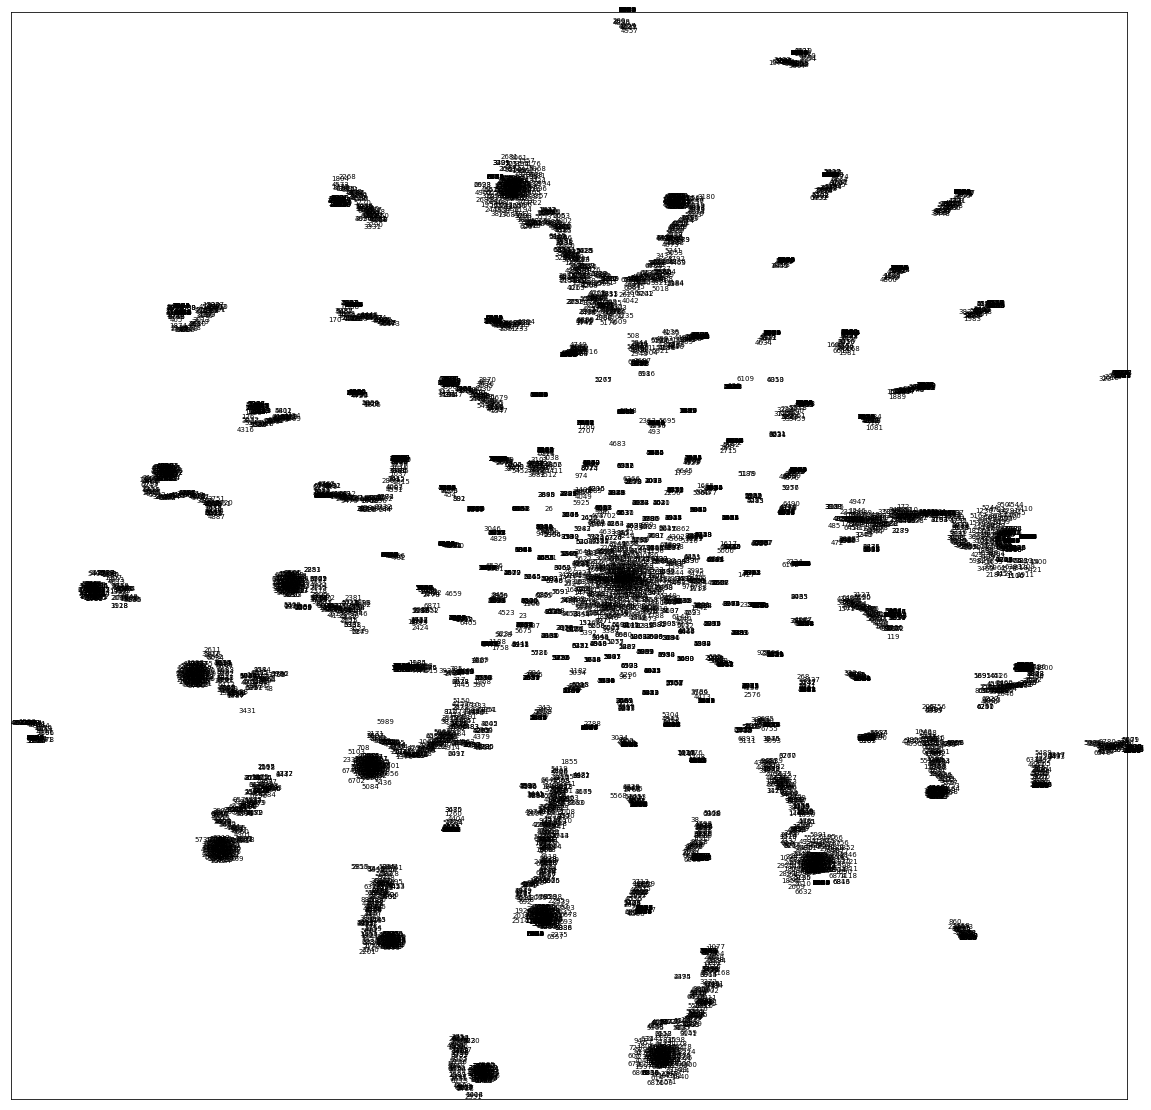

In [99]:
#Data Visualization
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize
plt.figure(figsize=(20, 20))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], s = i, size = 7)
plt.xticks([])
plt.yticks([])
plt.show()

# Test data

In [22]:
my_train = pd.crosstab(y_train.client_id, y_train.title, normalize='index')
classy_train = list(my_train.columns)
my_train = np.array(my_train)

my_test = pd.crosstab(y_test.client_id, y_test.title, normalize='index')
classy_test = list(my_test.columns)
my_test = np.array(my_test)

#Model Building

In [23]:
import numpy as np
import pandas as pd
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Reshape, BatchNormalization, LSTM, Reshape
from keras.models import Model
warnings.filterwarnings('ignore')
%matplotlib inline

In [24]:
print(mx_train.shape)
print(mx_test.shape)
print(mx_train1.shape)
print(mx_test1.shape)
print(my_train.shape)
print(my_test.shape)

(6968, 227)
(2323, 227)
(6968, 24)
(2323, 24)
(6968, 219)
(2323, 188)


In [25]:
def model_build():
  # Input Layer
  user_input = Input(shape=(mx_train.shape[1], ), name = "User-Input")
  user_vec = Dense(32, activation='relu')(user_input)

  pattern_input = Input(shape=(mx_train1.shape[1], ), name = "Pattern-Input")
  pattern_vec = Dense(8, activation='relu')(pattern_input)

  # Concatenate Features
  conc = Concatenate()([user_vec, pattern_vec])

  # Fully Connected Layer
  fc2 = BatchNormalization()(conc)
  fc3 = Dense(32, activation='relu')(fc2)
  fc4 = BatchNormalization()(fc3)
  fc5 = Dense(128, activation='relu')(fc4)
  fc6 = BatchNormalization()(fc5)

  # Output Layer
  out = Dense(my_train.shape[1], activation = 'softmax')(fc6)

  model = Model(inputs = [user_input, pattern_input], outputs = out)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [26]:
model = model_build()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User-Input (InputLayer)        [(None, 227)]        0           []                               
                                                                                                  
 Pattern-Input (InputLayer)     [(None, 24)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           7296        ['User-Input[0][0]']             
                                                                                                  
 dense_1 (Dense)                (None, 8)            200         ['Pattern-Input[0][0]']          
                                                                                              

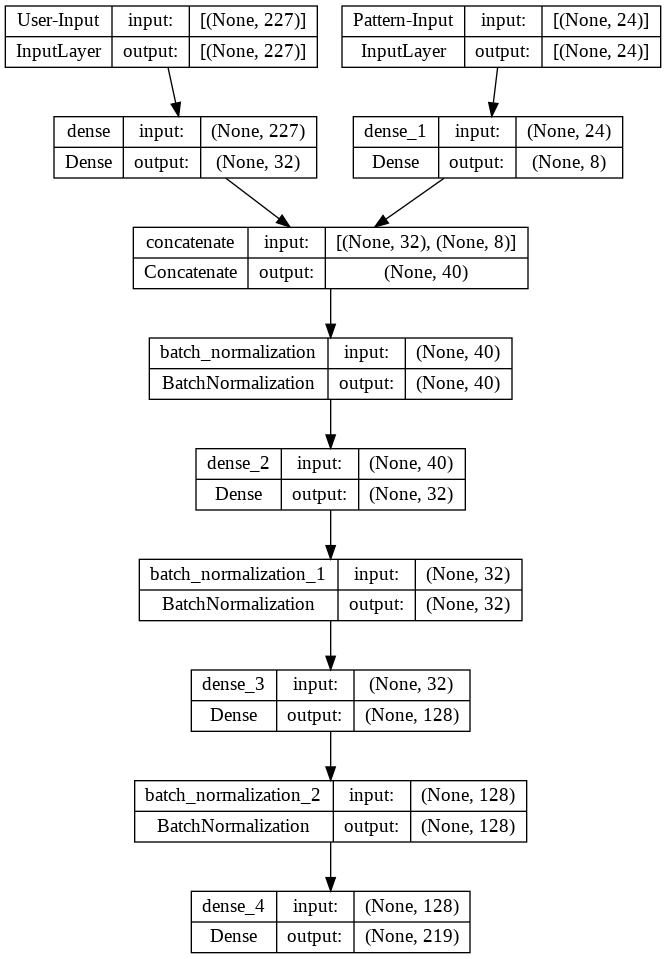

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#Model Training

In [28]:
import keras
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
history = model.fit([mx_train, mx_train1], my_train, epochs=100, verbose=True, batch_size = 128, callbacks=callbacks, validation_split = 0.15)

Epoch 1/100
47/47 [==============================] - 4s 13ms/step - loss: 4.2042 - accuracy: 0.3183 - val_loss: 5.1826 - val_accuracy: 0.1367
Epoch 2/100
47/47 [==============================] - 0s 8ms/step - loss: 2.5983 - accuracy: 0.5804 - val_loss: 4.9255 - val_accuracy: 0.2208
Epoch 3/100
47/47 [==============================] - 0s 8ms/step - loss: 2.1843 - accuracy: 0.6488 - val_loss: 4.6487 - val_accuracy: 0.2495
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 1.9566 - accuracy: 0.6778 - val_loss: 4.3358 - val_accuracy: 0.3069
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 1.8081 - accuracy: 0.6912 - val_loss: 3.9975 - val_accuracy: 0.3633
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: 1.6926 - accuracy: 0.7023 - val_loss: 3.6189 - val_accuracy: 0.4704
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: 1.5892 - accuracy: 0.7129 - val_loss: 3.2393 - val_accuracy: 0.5621
Epoch 8/100


#Performace Review

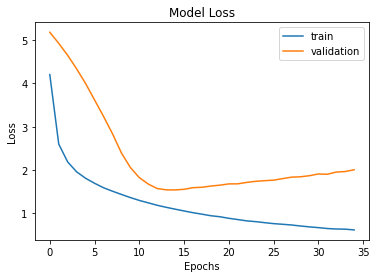

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

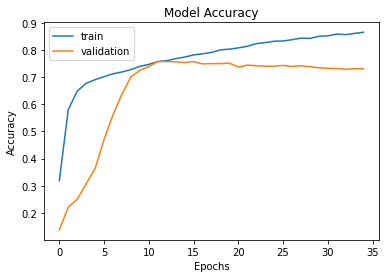

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [31]:
predictions = model.predict([mx_test, mx_test1])
pd.DataFrame(predictions, columns=classy_train)

73/73 [==============================] - 0s 2ms/step


,《新百家學堂》中國文學的美感,《新百家學堂》中華文化薪傳講座,《新百家學堂》亞洲共同體：東亞文學與文化,《新百家學堂》全球化的挑戰與因應,《新百家學堂》全球經濟與傳統儒學,《新百家學堂》古典抒情文學,《新百家學堂》宋代與女性有關的文學,《新百家學堂》崑曲新美學,《新百家學堂》機遇：臺灣當代抒情文學的異彩,《新百家學堂》氣候變遷對臺灣總體安全之衝擊,...,量子力學,量子化學,電磁學,電磁波,電腦輔助工程製圖,音樂、演化與大腦,韻文學專題,食品營養與安全概論,高等微積分,鯨豚保育生物學
0,0.006382,0.000127,0.000096,0.001021,0.000432,0.000056,0.000091,0.001500,0.000223,0.000167,...,0.000266,0.008431,0.000531,0.000662,0.000268,0.000264,0.003514,0.003835,0.003301,0.000443
1,0.000716,0.000834,0.000260,0.000035,0.000369,0.005539,0.000661,0.001084,0.001169,0.000249,...,0.000397,0.000615,0.001444,0.000346,0.000098,0.000208,0.000388,0.000023,0.006634,0.000434
2,0.000029,0.000450,0.000202,0.000009,0.000085,0.000029,0.000051,0.000092,0.000135,0.000052,...,0.000644,0.000060,0.000050,0.000324,0.000096,0.000041,0.000300,0.000047,0.000061,0.000021
3,0.000769,0.000133,0.000549,0.000031,0.000119,0.000342,0.000049,0.001741,0.000051,0.000187,...,0.000042,0.000045,0.000099,0.000003,0.000025,0.000578,0.000221,0.000017,0.000020,0.015401
4,0.000144,0.000460,0.000373,0.000137,0.000226,0.000103,0.000052,0.000126,0.000120,0.000468,...,0.448396,0.056114,0.000174,0.000214,0.000052,0.000045,0.000071,0.003862,0.000031,0.000437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,0.000132,0.000064,0.000620,0.000034,0.000039,0.000654,0.000437,0.000054,0.000116,0.000037,...,0.000132,0.000164,0.001661,0.000188,0.000154,0.000015,0.000025,0.000016,0.004445,0.000039
2319,0.000061,0.000122,0.000021,0.000432,0.000102,0.000014,0.000152,0.000057,0.000057,0.000192,...,0.000063,0.000205,0.000155,0.000164,0.000387,0.000020,0.001689,0.000466,0.000299,0.000015
2320,0.000235,0.000297,0.000187,0.000013,0.000256,0.003455,0.000440,0.000581,0.001342,0.000155,...,0.000513,0.000293,0.000753,0.000278,0.000077,0.000079,0.000236,0.000010,0.006864,0.000148
2321,0.000132,0.001313,0.000023,0.000447,0.000308,0.000014,0.000617,0.000084,0.000271,0.000207,...,0.000718,0.000638,0.000187,0.000557,0.000161,0.000134,0.000280,0.001922,0.000040,0.000028


In [32]:
predictions = np.argmax(predictions, axis = 1)

In [33]:
result = []
for i in predictions:
  result.append(classy_train[i])

In [34]:
compare = pd.DataFrame()
compare['Predict'] = result
compare['Real'] = list(y_test['title'])
compare

,Predict,Real
0,微積分,台灣法律史：從前不教的一門課
1,西洋哲學史,西洋哲學史
2,紅樓夢,紅樓夢
3,《新百家學堂》葉嘉瑩古典詩詞講座,《新百家學堂》葉嘉瑩古典詩詞講座
4,量子力學,量子力學
...,...,...
2318,微積分,微積分
2319,刑法總則一,刑法總則一
2320,西洋哲學史,廿世紀美國社會學理論
2321,財務管理,財務管理


In [35]:
from sklearn.metrics import accuracy_score
print("預測準確率 %.2f"%(accuracy_score(result, list(y_test['title']))))

預測準確率 0.69


# LSTM model with Embedding Structure

In [36]:
!pip install zhon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 5.1 MB/s 
  Created wheel for zhon: filename=zhon-1.1.5-py3-none-any.whl size=84321 sha256=33324e327ee1585b646de0aeb11acd01efb2a7f0f96390bd4b9be2440870a95d
  Stored in directory: /root/.cache/pip/wheels/c1/6a/5d/4cea6c295942b528462738b5c1bd96d7fddef29834eab57617
Successfully built zhon


In [37]:
import pandas as pd
import numpy as np

In [38]:
dataset = pd.read_csv('NewOCW.csv')
dataset = dataset.dropna()
dataset['client_id'] = dataset['client_id'].astype('str')
dataset['date'] = pd.to_datetime(dataset['date'])
dateset = dataset.sort_values(by='date', ascending=True, inplace=True)
dataset = dataset.drop(columns=['page', 'links'])

In [39]:
import re
from zhon.hanzi import punctuation

user_mappings = {k:v for v, k in enumerate(dataset['client_id'].unique())}
dataset['client_id'] = dataset['client_id'].map(user_mappings)

punctuation_str = punctuation
dataset['title_tokenized'] = list(map(lambda x: re.sub("[%s]+" %punctuation_str, "", x), dataset['title']))
class_mappings = {k:v for v, k in enumerate(dataset['title_tokenized'].unique())}
dataset['title_tokenized'] = dataset['title_tokenized'].map(class_mappings)

In [44]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le=LabelEncoder()
dataset['title_encoded'] = le.fit_transform(dataset['title'])

In [45]:
dataset.head(2)

,client_id,date,title,college,department,professor_name,total_click_times,month_click_times,title_tokenized,title_encoded
40893,0,2020-03-20 16:14:28.611336+00:00,古典社會學理論,社科院,社會學系,孫中興,196678,669,0,53
176733,1,2020-03-20 16:14:57.640742+00:00,英語語音學 (含發音練習) 一,文學院,外國語文學系,史嘉琳,1310409,7847,1,198


In [46]:
from random import sample
id = set(dataset['client_id'])
id_train = sample(id, int(len(id)*0.75))
id_test = []
for i in id:
  if i not in id_train:
    id_test.append(i)

print(len(id_train))
print(len(id_test))

7013
2338


In [47]:
train = dataset[dataset['client_id'].isin(id_train)]
test = dataset[dataset['client_id'].isin(id_test)]

In [48]:
# Use previous x-n behaviors to predict last n behaviors
from tqdm import tqdm

X_train = []
y_train = []
m = 75
for i in tqdm(set(train['client_id'])):
  temp = train[train['client_id'] == i]['title_tokenized'].values
  temp1 = train[train['client_id'] == i]['title_encoded'].values
  if len(temp) < m:
    continue
  temp = temp.reshape(-1, 1)
  temp1 = temp1.reshape(-1, 1)
  for j in range(m, temp.shape[0]):  
    X_train.append(temp[j-m:j, 0])
    y_train.append(temp1[j, 0].astype('float'))
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in tqdm(set(test['client_id'])):
  temp = test[test['client_id'] == i]['title_tokenized'].values
  temp1 = test[test['client_id'] == i]['title_encoded'].values
  if len(temp) < m:
    continue
  temp = temp.reshape(-1, 1)
  temp1 = temp1.reshape(-1, 1)
  for j in range(m, temp.shape[0]):  
    X_test.append(temp[j-m:j, 0])
    y_test.append(temp1[j, 0].astype('float'))
X_test, y_test = np.array(X_test), np.array(y_test)

100%|██████████| 2338/2338 [00:04<00:00, 469.36it/s]


In [49]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40176, 75)
(40176,)
(17750, 75)
(17750,)


In [50]:
import numpy as np
import pandas as pd
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Reshape, BatchNormalization, LSTM, Reshape, Bidirectional, TimeDistributed
from keras.models import Model
warnings.filterwarnings('ignore')
%matplotlib inline

In [51]:
embedding_size = len(set(y_train))

class_input = Input(shape=(X_train.shape[1], ), name = "Class-Input")
embedding_output =   behavior_embedding = Embedding(input_dim = X_train.shape[1]+1, 
                                output_dim = embedding_size, 
                                name = "Behavior-Embedding")(class_input)
embedding = Model(class_input, embedding_output, name = 'Encoder')
embedding.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Class-Input (InputLayer)    [(None, 75)]              0         
                                                                 
 Behavior-Embedding (Embeddi  (None, 75, 227)          17252     
 ng)                                                             
                                                                 
Total params: 17,252
Trainable params: 17,252
Non-trainable params: 0
_________________________________________________________________


In [52]:
decoder_input = Input(shape=(m, embedding_size, ), name="decoder_input")
# LSTM Layer 
lstm = LSTM(units = 32, return_sequences = True)(decoder_input)
bn = BatchNormalization()(lstm)
lstm_1 = LSTM(units = 16, return_sequences = True)(bn)
bn1 = BatchNormalization()(lstm_1)
lstm_2 = LSTM(units = 8, return_sequences = False)(bn1)
bn2 = BatchNormalization()(lstm_2)

# Fully Connected Layer
fc3 = Dense(32, activation='relu')(bn2)
fc4 = BatchNormalization()(fc3)
fc5 = Dense(128, activation='relu')(fc4)
fc6 = BatchNormalization()(fc5)

# Output Layer
out = Dense(len(set(y_train)), activation = 'softmax')(fc6)

decoder = Model(decoder_input, out, name = 'Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 75, 227)]         0         
                                                                 
 lstm (LSTM)                 (None, 75, 32)            33280     
                                                                 
 batch_normalization_3 (Batc  (None, 75, 32)           128       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 75, 16)            3136      
                                                                 
 batch_normalization_4 (Batc  (None, 75, 16)           64        
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800 

In [53]:
model_input = Input(shape=(X_train.shape[1], ))
embedding_output = embedding(model_input)
output = decoder(embedding_output)

model1 = Model(model_input, output)
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 Encoder (Functional)        (None, 75, 227)           17252     
                                                                 
 Decoder (Functional)        (None, 227)               71875     
                                                                 
Total params: 89,127
Trainable params: 88,695
Non-trainable params: 432
_________________________________________________________________


In [54]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

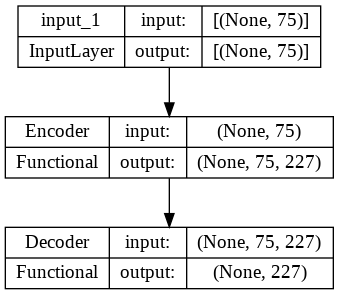

In [55]:
from tensorflow.keras.utils import plot_model
plot_model(model1, show_shapes=True)

In [56]:
import keras
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
history = model1.fit(X_train, y_train, epochs=100, verbose=True, batch_size = 512, callbacks=callbacks, validation_split = 0.15)

Epoch 1/100
67/67 [==============================] - 12s 40ms/step - loss: 3.1364 - accuracy: 0.4820 - val_loss: 5.1609 - val_accuracy: 0.0226
Epoch 2/100
67/67 [==============================] - 1s 21ms/step - loss: 2.1694 - accuracy: 0.5952 - val_loss: 4.9040 - val_accuracy: 0.1200
Epoch 3/100
67/67 [==============================] - 1s 21ms/step - loss: 1.9684 - accuracy: 0.6123 - val_loss: 4.6539 - val_accuracy: 0.1246
Epoch 4/100
67/67 [==============================] - 1s 21ms/step - loss: 1.8626 - accuracy: 0.6197 - val_loss: 4.2472 - val_accuracy: 0.1774
Epoch 5/100
67/67 [==============================] - 1s 21ms/step - loss: 1.7850 - accuracy: 0.6300 - val_loss: 3.8181 - val_accuracy: 0.3184
Epoch 6/100
67/67 [==============================] - 1s 22ms/step - loss: 1.7336 - accuracy: 0.6336 - val_loss: 3.2007 - val_accuracy: 0.4604
Epoch 7/100
67/67 [==============================] - 1s 21ms/step - loss: 1.6946 - accuracy: 0.6389 - val_loss: 2.7355 - val_accuracy: 0.5162
Epoch

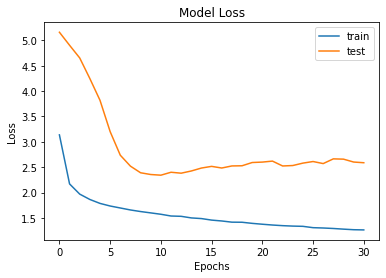

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

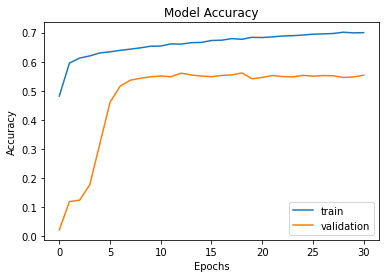

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [59]:
predictions = model1.predict(X_test)
predictions = np.argmax(predictions, axis = 1)
result = le.inverse_transform(predictions)

555/555 [==============================] - 6s 8ms/step


In [60]:
compare = pd.DataFrame()
compare['Predict'] = result
compare['Real'] = le.inverse_transform(y_test.astype('int'))
compare

,Predict,Real
0,刑法總則一,計算機程式
1,哲學與人生,《新百家學堂》西洋經典掃描
2,哲學與人生,計算機概論
3,哲學與人生,計算機概論
4,統計學,生態工程導論 (104學年)
...,...,...
17745,微積分,微積分
17746,微積分,微積分
17747,微積分,計算機程式
17748,微積分,有機化學


In [61]:
from sklearn.metrics import accuracy_score
print("預測準確率 %.2f"%(accuracy_score(result, le.inverse_transform(y_test.astype('int')))))

預測準確率 0.50


# Autoencoder for Segmentation

In [62]:
dataset = pd.read_csv('NewOCW.csv')
dataset = dataset.dropna()
dataset['client_id'] = dataset['client_id'].astype('str')
dataset['date'] = pd.to_datetime(dataset['date'])
dateset = dataset.sort_values(by='date', ascending=True, inplace=True)
dataset = dataset.drop(columns=['page', 'links'])

In [63]:
user_mappings = {k:v for v, k in enumerate(dataset['client_id'].unique())}
dataset['client_id'] = dataset['client_id'].map(user_mappings)

In [64]:
dataset['hour'] = list(map(lambda x: str(x)[11:13], dataset['date']))
cc = dataset.groupby('client_id')['title'].nunique()
cc = pd.DataFrame(cc)
cc = cc.rename(columns={'title': 'number'})
dataset = pd.merge(dataset, cc, on="client_id")
del cc

In [65]:
import time
from datetime import datetime

dataset['time_delta'] = (max(dataset['date']) - dataset['date'])
dataset['time_delta'] = list(map(lambda x: x.days, dataset['time_delta']))

In [66]:
r = 0.8
dataset['user_score'] = r**dataset['time_delta']

In [67]:
from random import sample
id = list(dataset['client_id'].unique())
id_train = sample(list(id), int(len(id)*0.75))
id_test = []
for i in id:
  if i not in id_train:
    id_test.append(i)

In [68]:
x_train = dataset[dataset['client_id'].isin(id_train)]
x_test = dataset[dataset['client_id'].isin(id_test)]

In [69]:
mx_train = pd.crosstab(x_train.client_id, x_train.title, normalize='index', values = x_train.user_score, aggfunc = np.sum)
mx_train = np.array(mx_train)

mx_test = pd.crosstab(x_test.client_id, x_test.title, normalize='index', values = x_test.user_score, aggfunc = np.sum)
mx_test = np.array(mx_test)

In [70]:
mx_train1 = pd.crosstab(x_train.client_id, x_train.hour, normalize='index')
mx_train1 = np.array(mx_train1)

mx_test1 = pd.crosstab(x_test.client_id, x_test.hour, normalize='index')
mx_test1 = np.array(mx_test1)

In [71]:
train = np.concatenate([mx_train, mx_train1], axis = 1)
test = np.concatenate([mx_test, mx_test1], axis = 1)

print(train.shape)
print(test.shape)

(7013, 251)
(2338, 251)


In [72]:
import numpy as np
import pandas as pd
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Reshape, BatchNormalization, LSTM, Reshape
from keras.models import Model
warnings.filterwarnings('ignore')
%matplotlib inline

In [73]:
encoding_dim = 3

user_input = Input(shape=(train.shape[1], ), name = "User-Input")
x = Dense(128, activation='relu')(user_input)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(8, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(4, activation='relu')(x)
x = BatchNormalization()(x)
encoded_output = Dense(encoding_dim, activation='relu')(x)

In [74]:
encoder = Model(user_input, encoded_output, name = 'Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 User-Input (InputLayer)     [(None, 251)]             0         
                                                                 
 dense_8 (Dense)             (None, 128)               32256     
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 32)                2080

In [75]:
decoder_input = Input(shape=(encoding_dim, ), name="decoder_input")
x = Dense(4, activation='relu')(decoder_input)
x = BatchNormalization()(x)
x = Dense(8, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
decoded_output = Dense(train.shape[1], activation='relu')(x)

In [76]:
decoder = Model(decoder_input, decoded_output, name = 'Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 3)]               0         
                                                                 
 dense_15 (Dense)            (None, 4)                 16        
                                                                 
 batch_normalization_14 (Bat  (None, 4)                16        
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 8)                 40        
                                                                 
 batch_normalization_15 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 16)                144 

In [77]:
ae_input = Input(shape=(train.shape[1], ), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

In [78]:
ae = Model(ae_input, ae_decoder_output, name="AE")
ae.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 251)]             0         
                                                                 
 Encoder (Functional)        (None, 3)                 44315     
                                                                 
 Decoder (Functional)        (None, 251)               44563     
                                                                 
Total params: 88,878
Trainable params: 87,870
Non-trainable params: 1,008
_________________________________________________________________


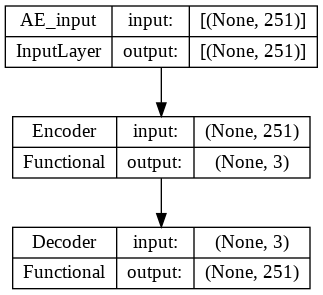

In [79]:
from tensorflow.keras.utils import plot_model
plot_model(ae, show_shapes=True)

In [80]:
ae.compile(optimizer='adam', loss='mse', metrics = ['mae'])

In [81]:
import keras
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

History = ae.fit(train, train, epochs=100, batch_size=128, shuffle=True, validation_split = 0.1, callbacks=callbacks)

Epoch 1/100
50/50 [==============================] - 4s 20ms/step - loss: 0.0621 - mae: 0.1161 - val_loss: 0.0053 - val_mae: 0.0221
Epoch 2/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0053 - mae: 0.0243 - val_loss: 0.0083 - val_mae: 0.0341
Epoch 3/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0041 - mae: 0.0150 - val_loss: 0.0118 - val_mae: 0.0431
Epoch 4/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0038 - mae: 0.0123 - val_loss: 0.0122 - val_mae: 0.0419
Epoch 5/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0038 - mae: 0.0116 - val_loss: 0.0112 - val_mae: 0.0378
Epoch 6/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0037 - mae: 0.0106 - val_loss: 0.0090 - val_mae: 0.0312
Epoch 7/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0037 - mae: 0.0099 - val_loss: 0.0067 - val_mae: 0.0238
Epoch 8/100
50/50 [==============================] - 1s 11ms/step - loss: 0.

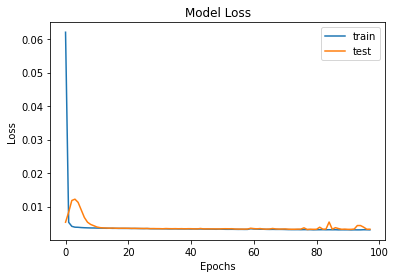

In [82]:
import matplotlib.pyplot as plt
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [83]:
ae.evaluate(test, test)

74/74 [==============================] - 0s 4ms/step - loss: 0.0031 - mae: 0.0076


[0.003085265401750803, 0.007558275945484638]

In [84]:
user = np.concatenate([train, test], axis = 0)
encoded_data = encoder.predict(user)
decoded_data = decoder.predict(encoded_data)

293/293 [==============================] - 1s 2ms/step


In [85]:
columns_names = []
for i in range(encoding_dim):
  columns_names.append('dim_'+str(i+1))
result = pd.DataFrame(encoded_data, columns = columns_names)

In [86]:
result

,dim_1,dim_2,dim_3
0,1.318835,0.236743,0.000000
1,0.000000,0.792237,0.000000
2,0.000000,0.342393,0.229532
3,0.000000,0.000000,4.785927
4,1.171112,0.272452,0.000000
...,...,...,...
9346,1.324877,0.236490,0.000000
9347,0.000000,0.602101,0.000000
9348,0.000000,0.000000,1.337471
9349,1.324877,0.236490,0.000000


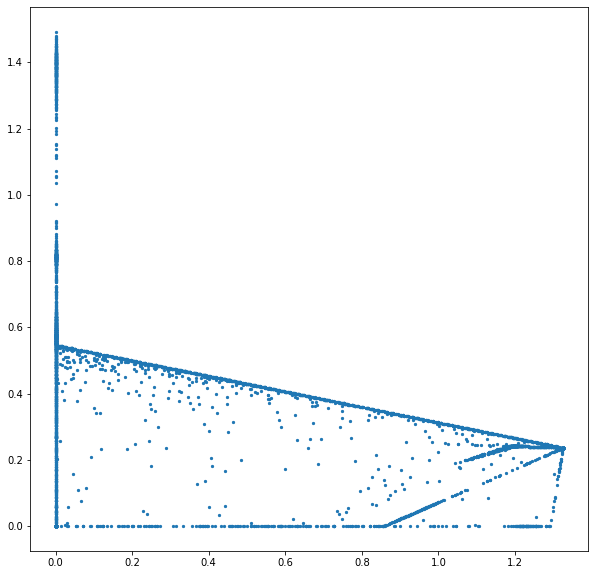

In [87]:
plt.figure(figsize=(10, 10)) 
plt.scatter(result["dim_1"], result["dim_2"], s = 5)

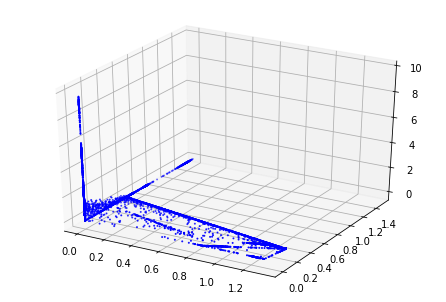

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure()

ax = Axes3D(fig)
ax.scatter(result["dim_1"], result["dim_2"], result['dim_3'], c ='blue', s = 1)

plt.show()

In [89]:
from sklearn import metrics
from sklearn.cluster import KMeans
from tqdm import tqdm

clusters = range(2,50)
sc_scores = []
for k in tqdm(clusters):
  kmeans_model = KMeans(n_clusters=k).fit(result)
  sc_score = metrics.silhouette_score(result, kmeans_model.labels_,sample_size=10000, metric='euclidean')
  sc_scores.append(sc_score)
print(sc_scores)
best_clusters = sc_scores.index(max(sc_scores))+2
print(best_clusters)

100%|██████████| 48/48 [01:03<00:00,  1.32s/it]

[0.83189666, 0.6327963, 0.6994444, 0.7160607, 0.71240455, 0.7332472, 0.7179158, 0.71955603, 0.71888053, 0.70087457, 0.7009488, 0.6999589, 0.6840709, 0.6947572, 0.68285626, 0.6978808, 0.6936079, 0.68596613, 0.70015836, 0.70115787, 0.70239884, 0.7024465, 0.70275646, 0.7028737, 0.7006529, 0.72012585, 0.71692073, 0.7178829, 0.7054109, 0.7227322, 0.72266406, 0.712459, 0.7208914, 0.71431106, 0.7138838, 0.7095371, 0.6980428, 0.7119407, 0.69874936, 0.7105118, 0.70768344, 0.6901994, 0.6862475, 0.7042943, 0.6843523, 0.6877217, 0.69238555, 0.6886094]
2


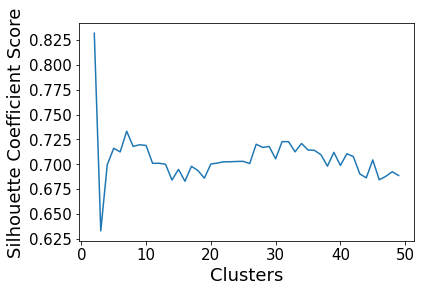

In [90]:
plt.figure()
plt.plot(clusters, sc_scores, )
plt.xlabel('Clusters',fontsize=18)
plt.ylabel('Silhouette Coefficient Score',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

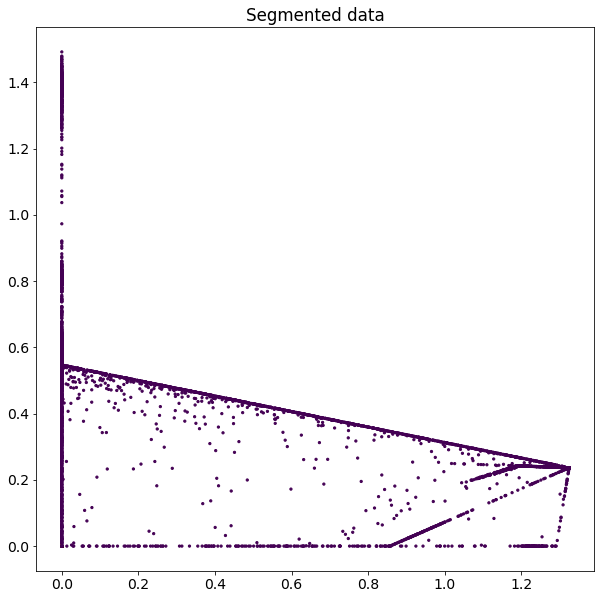

In [91]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=best_clusters)
kmeans.fit(result)

plt.rcParams['font.size'] = 14
plt.figure(figsize=(10, 10))
plt.title('Segmented data')
plt.scatter(result['dim_1'], result['dim_2'], c = kmeans.predict(result), s = 5)

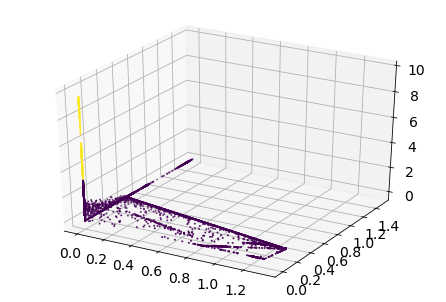

In [92]:
fig = plt.figure()

ax = Axes3D(fig)
ax.scatter(result["dim_1"], result["dim_2"], result['dim_3'], c = kmeans.predict(result), s = 1)

plt.show()